In [1]:
from torchtext import data
from torchtext import datasets
import torch
import random

TEXT = data.Field(sequential=True, tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(sequential=False, dtype = torch.long)
train_data, test_data = data.TabularDataset.splits(
                            path = './AA/data/',
                            train='train.tsv',
                            test ="test.tsv",
                            format = 'tsv',
                            fields = [
                                ("PhraseId", None),
                                ("SentenceId", None), 
                                ("text", TEXT),
                                ("label", LABEL)
                            ],
                            skip_header=True
)
train_data, valid_data = train_data.split(random_state = random.seed(42))

In [2]:
print(vars(train_data[0]))
print(vars(valid_data[0]))
print(vars(test_data[0]))
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

{'text': ['sensitive', ',', 'smart', ',', 'savvy', ',', 'compelling', 'coming', '-', 'of', '-', 'age', 'drama'], 'label': '4'}
{'text': ['acrid'], 'label': '1'}
{'text': ['An', 'intermittently', 'pleasing', 'but', 'mostly', 'routine', 'effort', '.']}
Number of training examples: 109242
Number of validation examples: 46818
Number of testing examples: 66292


In [3]:
TEXT.build_vocab(train_data,vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [4]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 17080
Unique tokens in LABEL vocabulary: 5


In [5]:
BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.text),
    device = device)

In [6]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout)
        self.predictor = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):

        embedded = self.dropout(self.embedding(text))    
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        
        return self.predictor(hidden)

In [7]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [8]:
print(vars(train_iterator.dataset[0]))

pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

{'text': ['sensitive', ',', 'smart', ',', 'savvy', ',', 'compelling', 'coming', '-', 'of', '-', 'age', 'drama'], 'label': '4'}
torch.Size([17080, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1431,  0.0487,  0.0565,  ..., -0.0402, -0.3744,  0.5650],
        [ 0.1407,  0.4159,  0.0536,  ...,  0.4412,  0.2128,  0.8328],
        [-0.7293,  0.4543,  0.3404,  ..., -0.6874, -0.9046,  0.3675]])


In [9]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [10]:
def batch_accuracy(predictions, label): #
    preds = torch.argmax(predictions.data, dim=1)
    correct = (preds == label).sum().item()
    accuracy = correct / list(predictions.size())[0]
    return accuracy, preds ,label    
    
def timer(start_time, end_time):
    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))
    return mins, secs

In [11]:
from math import *
import torch

def train(model, iterator, optimizer, criterion):
    
    training_loss = 0.0
    training_acc = 0.0
    model.train()
    list_preds = []
    list_labels = []
    
    for batch in iterator:
        
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions.squeeze(0), batch.label)
        accuracy,preds,label = batch_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        
        list_preds.append(preds)
        list_labels.append(label)

        training_loss += loss.item()
        training_acc += accuracy

    return training_loss / len(iterator), training_acc / len(iterator) , list_preds, list_labels 

def evaluate(model, iterator, criterion):
    eval_loss = 0.0
    eval_acc = 0
    model.eval()
    list_preds = []
    list_labels = []
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions.squeeze(0), batch.label)
            accuracy,preds,label = batch_accuracy(predictions, batch.label)
            list_preds.append(preds)
            list_labels.append(label)
            eval_loss += loss.item()
            eval_acc += accuracy
            
    return eval_loss / len(iterator), eval_acc / len(iterator) , list_preds, list_labels 

In [16]:
import time
from sklearn.metrics import confusion_matrix
NUM_EPOCHS = 20

best_valid_loss = float('inf')
train_loss_tab = []
train_acc_tab = []
valid_loss_tab = []
valid_acc_tab = []

epoch = 0
best_epoch = 0
while(epoch - best_epoch <= 10):
    start_time = time.time()
    train_loss, train_acc, list_preds, list_labels   = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, list_preds_valid, list_labels_valid = evaluate(model, valid_iterator, criterion) 
    end_time = time.time()
    mins, secs = timer(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'model-small.pt')
        
        
    real_preds = []  
    for tensor_preds in list_preds : 
        for elem in tensor_preds.data.cpu().numpy() : 
            real_preds.append(elem)
            
    real_labels = []
    for tensor_labels in list_labels : 
        for elem in tensor_labels.data.cpu().numpy() : 
            real_labels.append(elem)
            
            
    real_preds_valid = []
    for tensor_preds in list_preds_valid : 
        for elem in tensor_preds.data.cpu().numpy() : 
            real_preds_valid.append(elem)
            
            
    real_labels_valid = []
    for tensor_preds in list_labels_valid : 
        for elem in tensor_preds.data.cpu().numpy() : 
            real_labels_valid.append(elem) 
            
            
            
    train_loss_tab.append(train_loss)
    train_acc_tab.append(train_acc)
    valid_loss_tab.append(valid_loss)
    valid_acc_tab.append(valid_acc)
    
    
    print("\nEpoque {}:".format(epoch+1))
    print("\t Temps: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Accuracy sur le train: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Accuracy sur la validation: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))
    
    print("\t matrice de confusion sur le corpus de train :\n")
    print(confusion_matrix(real_labels, real_preds))
    
    print("\t matrice de confusion sur le corpus de dev :\n")
    print(confusion_matrix(real_labels_valid, real_preds_valid))
    epoch += 1


Epoque 1:
	 Temps: 0m 14s
	 Train Loss 0.73 | Accuracy sur le train: 69.86%
	 Validation Loss 0.81 | Accuracy sur la validation: 66.25%
	 matrice de confusion sur le corpus de train :

[[46426  4359  4738    77   144]
 [ 7393 13831   674  1227    15]
 [ 5996   493 11704     9   888]
 [  322  3370    74  2564     5]
 [  332    50  2749     8  1794]]
	 matrice de confusion sur le corpus de dev :

[[17480  2640  3448   122   148]
 [ 2412  5665   470  1228    12]
 [ 1793   269  5345    10   766]
 [   94  1176    41  1556     4]
 [   83    19  1057     3   977]]

Epoque 2:
	 Temps: 0m 15s
	 Train Loss 0.73 | Accuracy sur le train: 69.73%
	 Validation Loss 0.8 | Accuracy sur la validation: 66.81%
	 matrice de confusion sur le corpus de train :

[[46319  4403  4807    69   146]
 [ 7359 13821   684  1254    22]
 [ 6087   487 11633     5   878]
 [  318  3323    61  2628     5]
 [  363    47  2739     5  1779]]
	 matrice de confusion sur le corpus de dev :

[[17943  2558  3074    92   171]
 [ 2

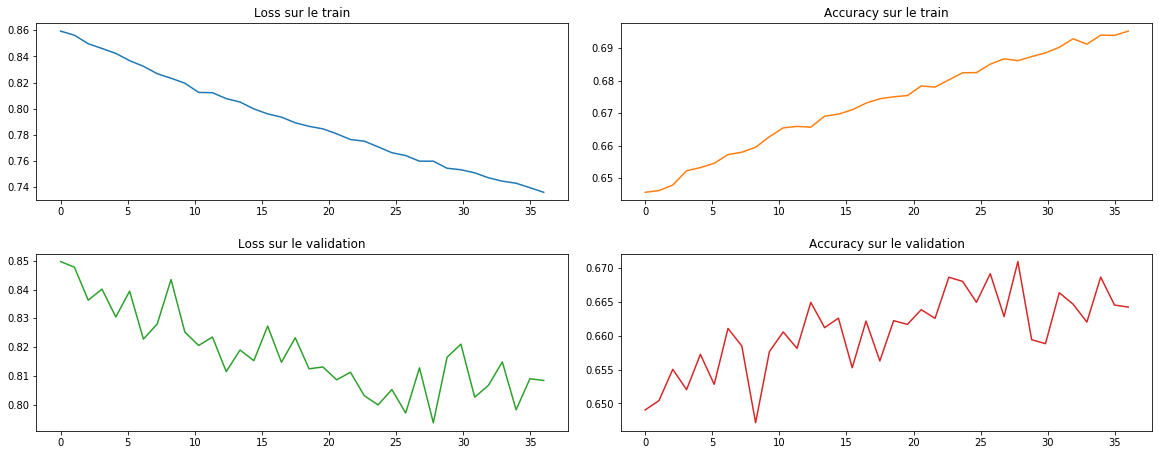

In [15]:
import matplotlib.pyplot as plt
import numpy as np

tab1 = []
fig, axs = plt.subplots(2, 2, figsize=(20,7.5))
plt.subplots_adjust(hspace=0.3, wspace=0.1)
x = np.linspace(0, epoch, epoch)
axs[0, 0].plot(x, train_loss_tab)
axs[0, 0].set_title('Loss sur le train')
axs[0, 1].plot(x, train_acc_tab, 'tab:orange')
axs[0, 1].set_title('Accuracy sur le train')
axs[1, 0].plot(x, valid_loss_tab, 'tab:green')
axs[1, 0].set_title('Loss sur le validation')
axs[1, 1].plot(x, valid_acc_tab, 'tab:red')
axs[1, 1].set_title('Accuracy sur le validation')
plt.savefig('books_read.png')
plt.show()